In [1]:
import os
import torch
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import cv2
from typing import Optional, Union, Tuple, List, Callable, Dict
from IPython.display import display, HTML
from tqdm.notebook import tqdm
import torch.nn.functional as nnf
from diffusers import DiffusionPipeline
import abc
from ProT2I.processors import *
import matplotlib.pyplot as plt
from torchvision.utils import save_image



In [2]:
def text_under_image(image: np.ndarray, text: str, text_color: Tuple[int, int, int] = (0, 0, 0)):
    h, w, c = image.shape
    offset = int(h * .2)
    img = np.ones((h + offset, w, c), dtype=np.uint8) * 255
    font = cv2.FONT_HERSHEY_SIMPLEX
    # font = ImageFont.truetype("/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf", font_size)
    img[:h] = image
    textsize = cv2.getTextSize(text, font, 1, 2)[0]
    text_x, text_y = (w - textsize[0]) // 2, h + offset - textsize[1] // 2
    cv2.putText(img, text, (text_x, text_y ), font, 1, text_color, 2)
    return img

def view_images(images, num_rows=1, offset_ratio=0.02):
    if type(images) is list:
        if isinstance(images[0], Image.Image):
            h, w = images[0].size
            images = [np.array(img) for img in images]
        num_empty = len(images) % num_rows
    elif images.ndim == 4:
        num_empty = images.shape[0] % num_rows
    else:
        images = [images]
        num_empty = 0

    empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
    images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
    num_items = len(images)

    h, w, c = images[0].shape
    offset = int(h * offset_ratio)
    num_cols = num_items // num_rows
    image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                      w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
    for i in range(num_rows):
        for j in range(num_cols):
            image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                i * num_cols + j]

    pil_img = Image.fromarray(image_)
    display(pil_img)


    
def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(2, -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0, words: List[str] = None, is_cross: bool = True, save_dir: str = "attention_maps"):
    # 确保保存目录存在
    os.makedirs(save_dir, exist_ok=True)
    
    tokens = tokenizer.encode(nps[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, is_cross, select) * 100
    images = []
    if words:
        token_texts = [decoder(int(token)) for token in tokens]
        token_indices = [i for i, text in enumerate(token_texts) if text in words]
    else:
        token_indices = range(len(tokens))
    
    for i in token_indices:
        image = attention_maps[:, :, i]
        image = (image - image.min()) / (image.max() - image.min())  # 归一化到0-1范围
        image = 255 * (image ** 0.85)  # 强化高亮区域，对比度进一步提升
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
        
        # 保存图片到本地，文件名为 token 的解码文本
        filename = os.path.join(save_dir, f"{decoder(int(tokens[i]))}_{i}.png")
        Image.fromarray(image).save(filename)
        
    view_images(np.stack(images, axis=0))

def show_images(desc:List[str], images:List, num_rows:int=1, Offset_ratio:float=0.02):
    imgs = []
    assert len(desc) == len(images), "Length of desc and images should be equal."
    for i, image in enumerate(images):
        if isinstance(image, Image.Image):
            image = np.array(image.resize((256, 256)))
        image = text_under_image(image, desc[i])
        imgs.append(image)
    view_images(np.stack(imgs, axis=0), num_rows=num_rows,offset_ratio=Offset_ratio)
        

def show_self_attention(attention_stores:List[AttentionStore], from_where: str, layers:int):
    top_components = []
    # the first self attention map
    first_attention_map = attention_stores[0].get_average_attention()[from_where][layers][:8].mean(dim=0)
    U, S, V = torch.svd(first_attention_map.to(torch.float32))
    top_U = U[:, :6]
    top_components.append(top_U)
    for i, attention_store in enumerate(attention_stores, start=0):
        attention_map = (attention_store.get_average_attention()[from_where][layers][8:]).mean(dim=0).to(torch.float32)
        U, S, V = torch.svd(attention_map)
        top_U = U[:,:6]
        top_components.append(top_U)

    for batch_idx, components in enumerate(top_components):
        plt.figure(figsize=(24, 4))
        for comp_idx in range(6):
            plt.subplot(1, 6, comp_idx + 1)
            component = components[:,comp_idx].reshape(16,16).to('cpu')
            plt.imshow(component, cmap='viridis')
            # plt.colorbar()
            plt.axis('off')
            plt.title(f'prompt {batch_idx + 1} Top {comp_idx + 1}')
        plt.tight_layout()
        plt.show()
    

## SD1_5

In [3]:
from ProT2I.prot2i_pipeline_sd_1_5 import ProT2IPipeline
from ProT2I.processors import create_controller

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
if device.type == "cuda":
    pipe = ProT2IPipeline.from_pretrained("SG161222/Realistic_Vision_V5.1_noVAE",
                                                torch_dtype=torch.float16, use_safetensors=True).to(device)
else:
    pipe = ProT2IPipeline.from_pretrained("SG161222/Realistic_Vision_V5.1_noVAE",
                                                torch_dtype=torch.float32, use_safetensors=False).to(device)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

<class 'ProT2I.prot2i_pipeline_sd_1_5.ProT2IPipeline'>


  0%|          | 0/50 [00:00<?, ?it/s]

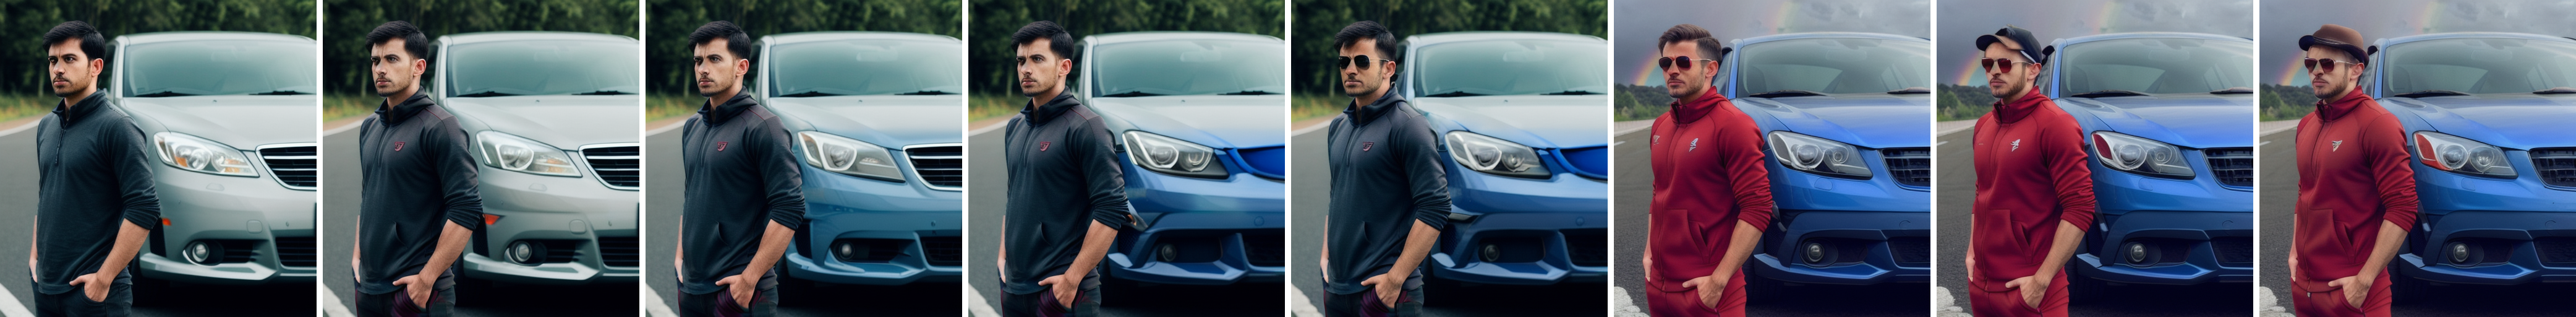

In [4]:
seed = 3254
g_cpu = torch.Generator().manual_seed(seed)
prompts = ["a man in a red tracksuit wearing sunglasses and a brown hat stand in front of a blue sport car with a rainbow in the background"]

nps = [
    "a man stand in front of a car", 
    "a man in a red tracksuit stand in front of a car",
    "a man in a red tracksuit stand in front of a blue car", 
    "a man in a red tracksuit stand in front of a blue sport car", 
    "a man in a red tracksuit wearing sunglasses stand in front of a blue sport car",
    "a man in a red tracksuit wearing sunglasses stand in front of a blue sport car with a rainbow in the background",
    "a man in a red tracksuit wearing sunglasses and a hat stand in front of a blue sport car with a rainbow in the background",
    "a man in a red tracksuit wearing sunglasses and a brown hat stand in front of a blue sport car with a rainbow in the background",
]
lb_words_list = [("man","man"),  ("car","car"), ("car","car"), ("man","man"), None, ("man","man"), ("hat","hat")]

# 定制controller
n_cross_replace = 0.0
n_self_replace = 0.8
attn_res = (32,32)
lb_threshold = 0.4
controller_np = [[nps[i-1],nps[i]] for i in range(1, len(nps))]
controller_list = []
controller_np = [[nps[i-1],nps[i]] for i in range(1, len(nps))]
for i in range(len(lb_words_list)):
    controller_kwargs = {
        "edit_type": "refine",
        "local_blend_words": lb_words_list[i],
        "equalizer_words": None,
        "equalizer_strengths": None,
        "n_cross_replace": {"default_": n_cross_replace},
        "n_self_replace": n_self_replace,
        "lb_threshold": lb_threshold,
    }
    controller = create_controller(prompts=controller_np[i], cross_attention_kwargs=controller_kwargs, num_inference_steps=50,tokenizer=pipe.tokenizer, device=device, attn_res=attn_res, structured_cond=None)
    controller_list.append(controller)


cross_attention_kwargs = {
    "nps": nps,
    "set_controller": controller_list,
    }

print(type(pipe))
p2p_output = pipe(prompts, cross_attention_kwargs=cross_attention_kwargs, num_inference_steps=50, num_images_per_prompt=1,generator=g_cpu)
view_images(p2p_output[0]["images"])

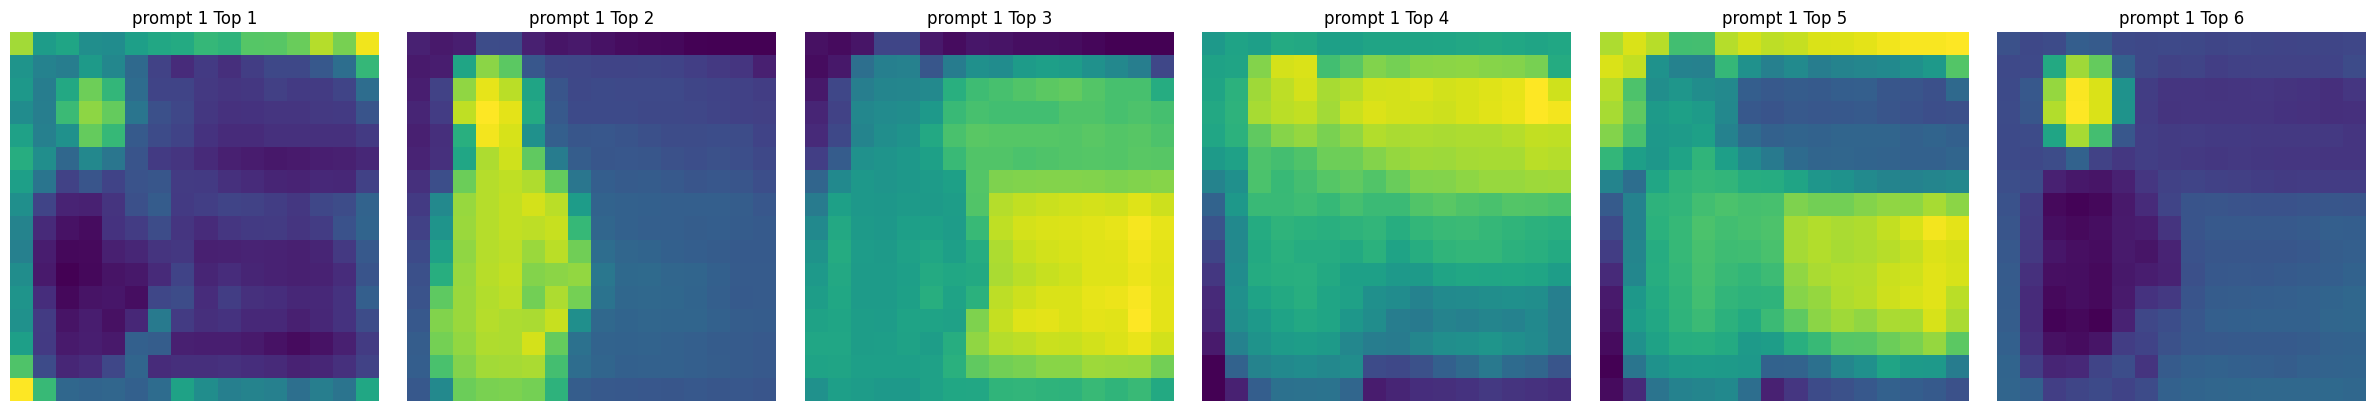

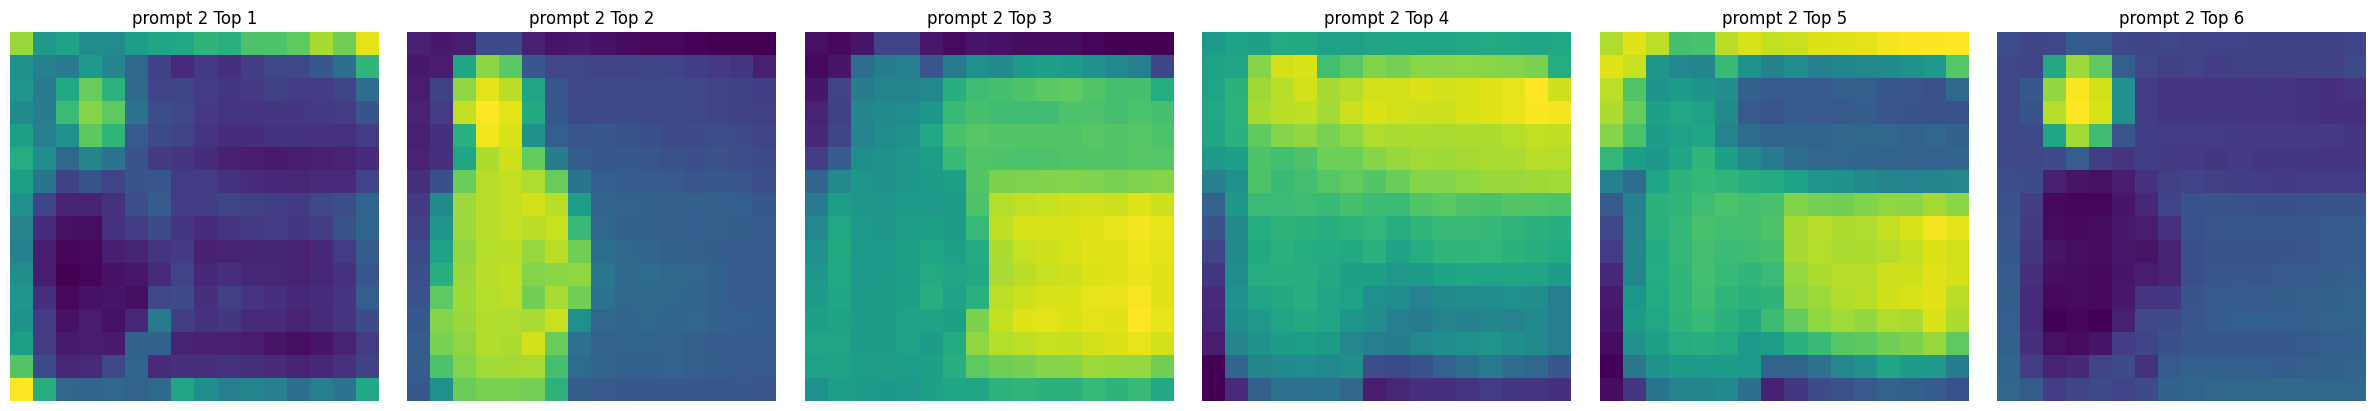

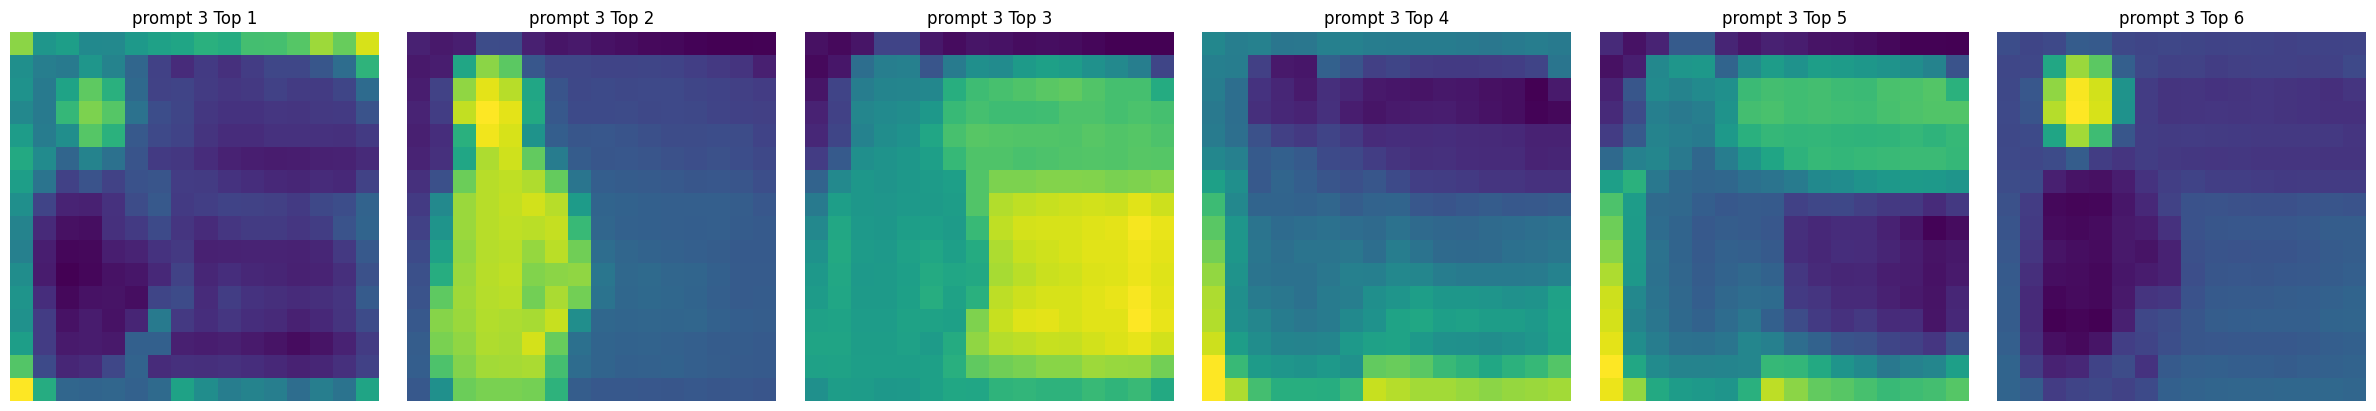

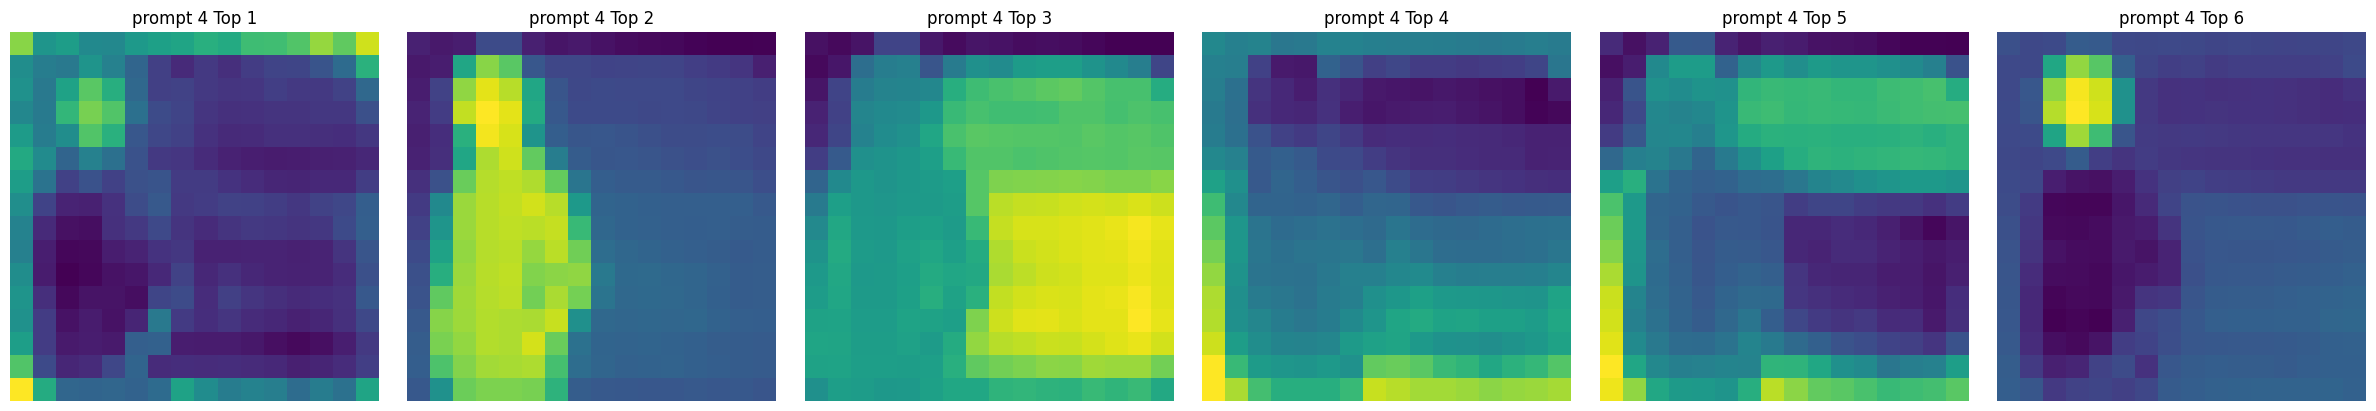

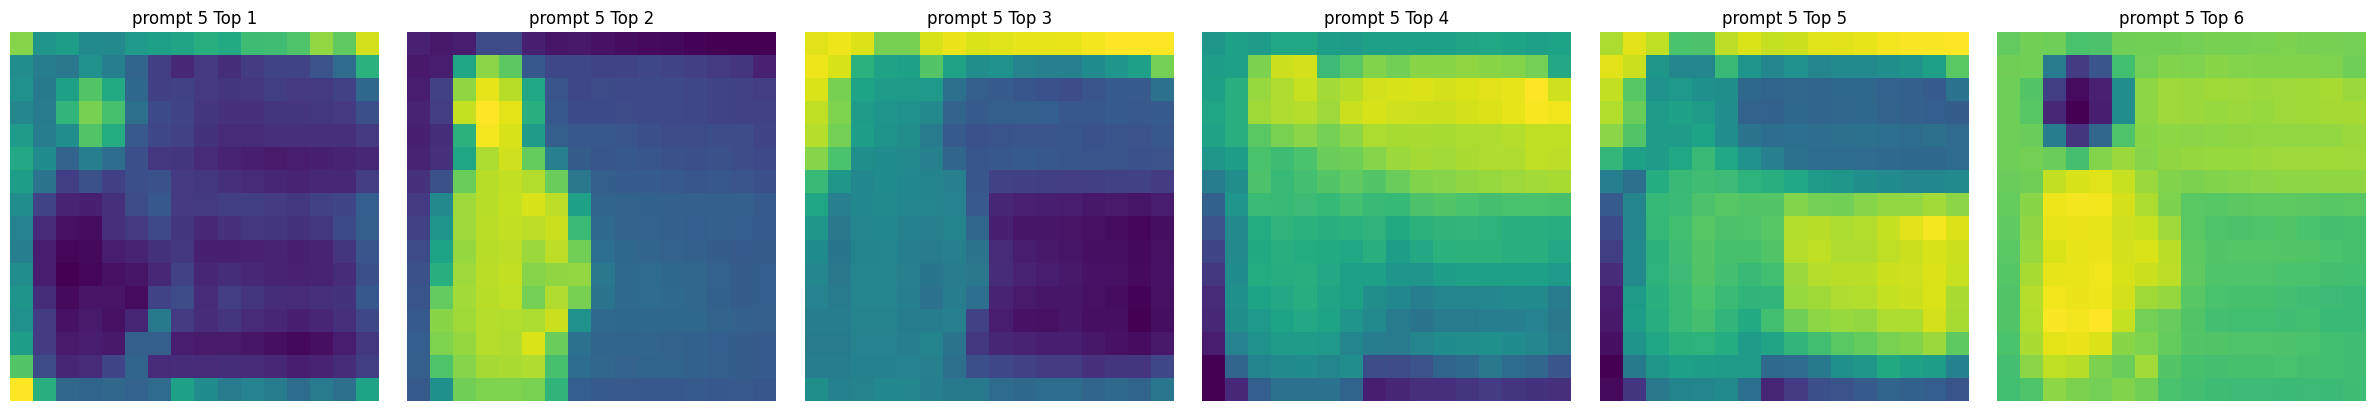

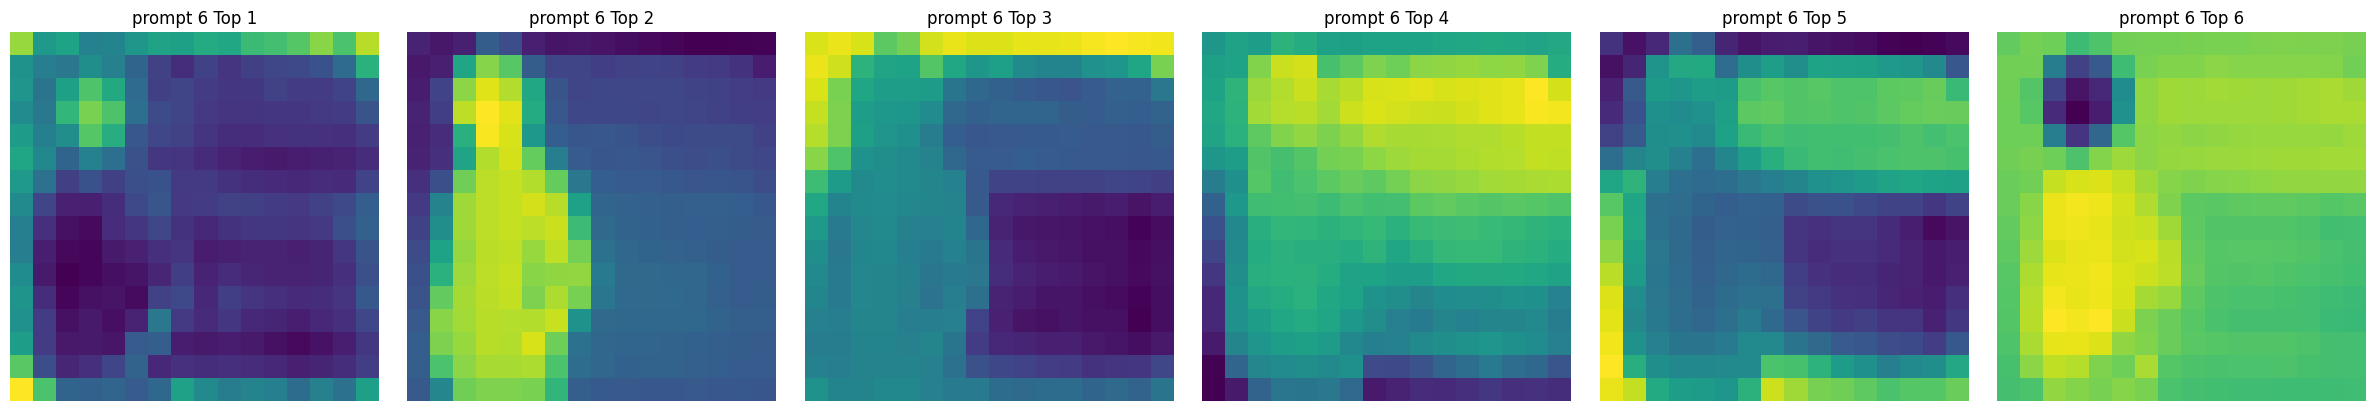

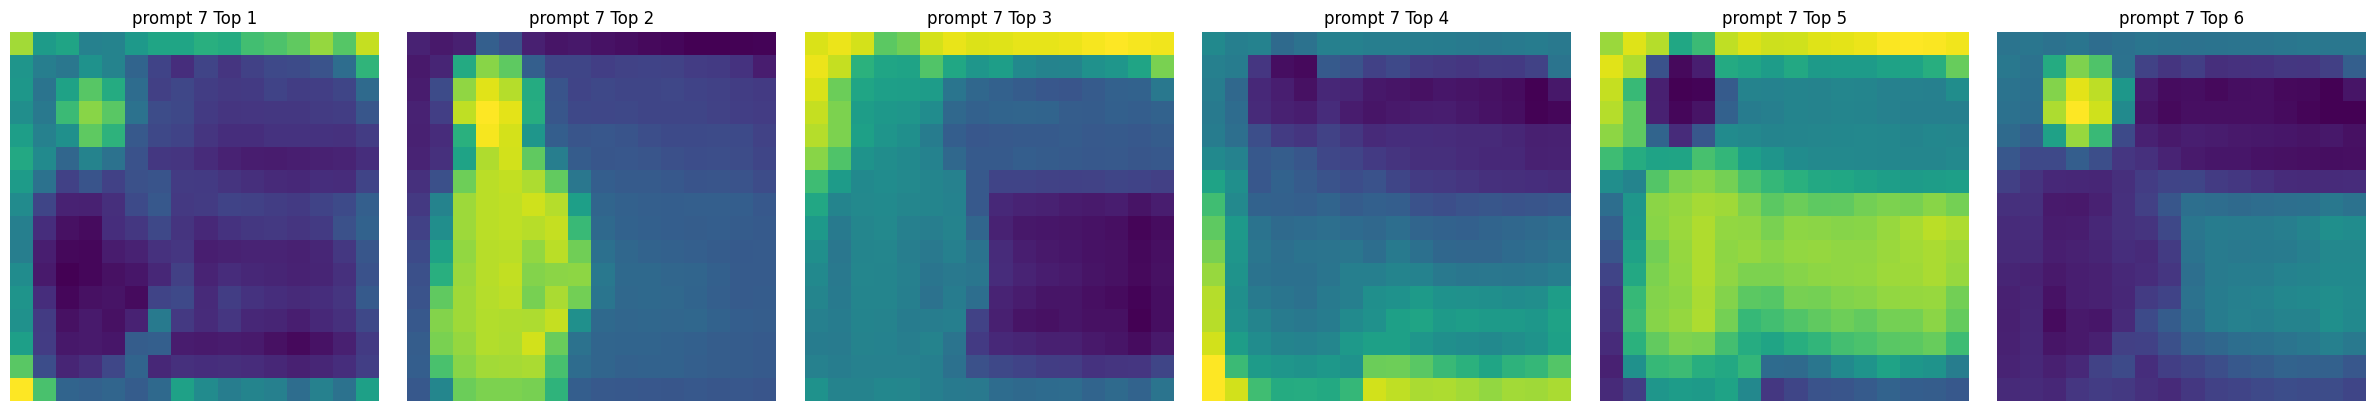

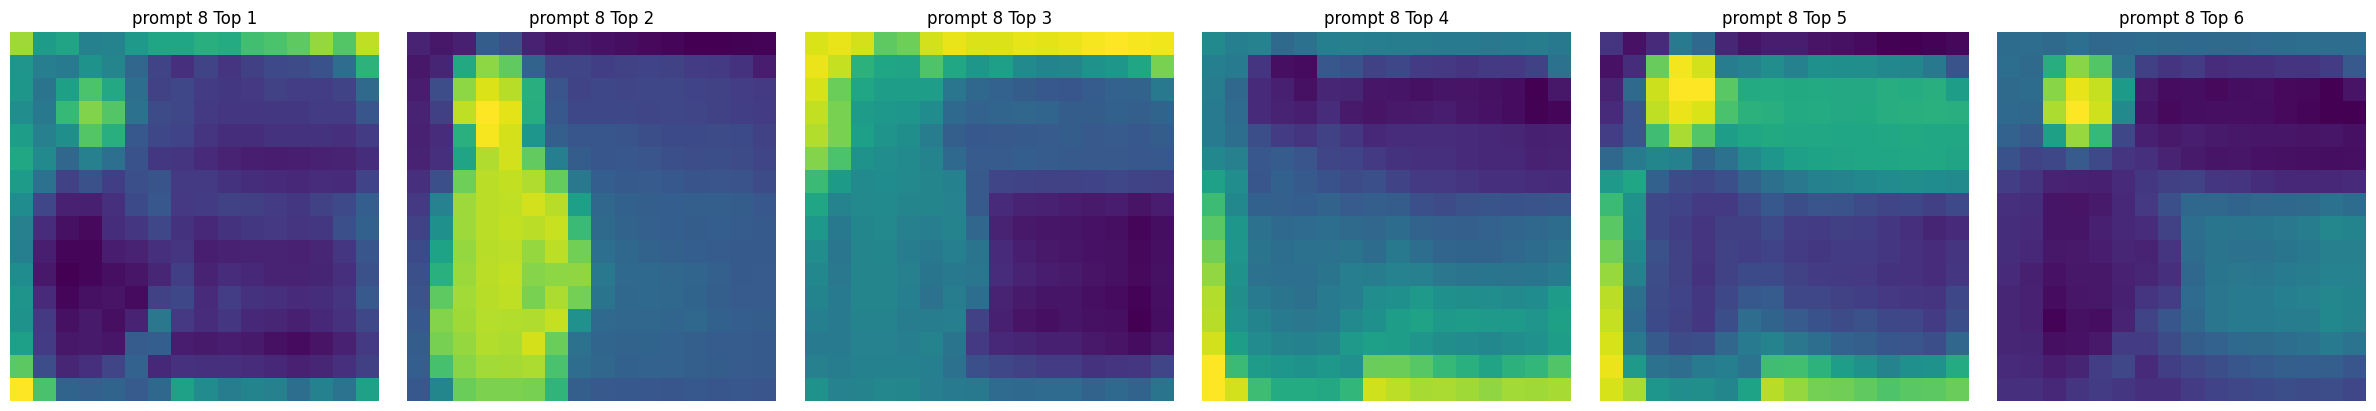

In [5]:
# from_where "down_self" "mid_self" "up_self" 
# layers down 0-3 mid 0 up 0-5
show_self_attention(controller_list,"up_self", layers=0)

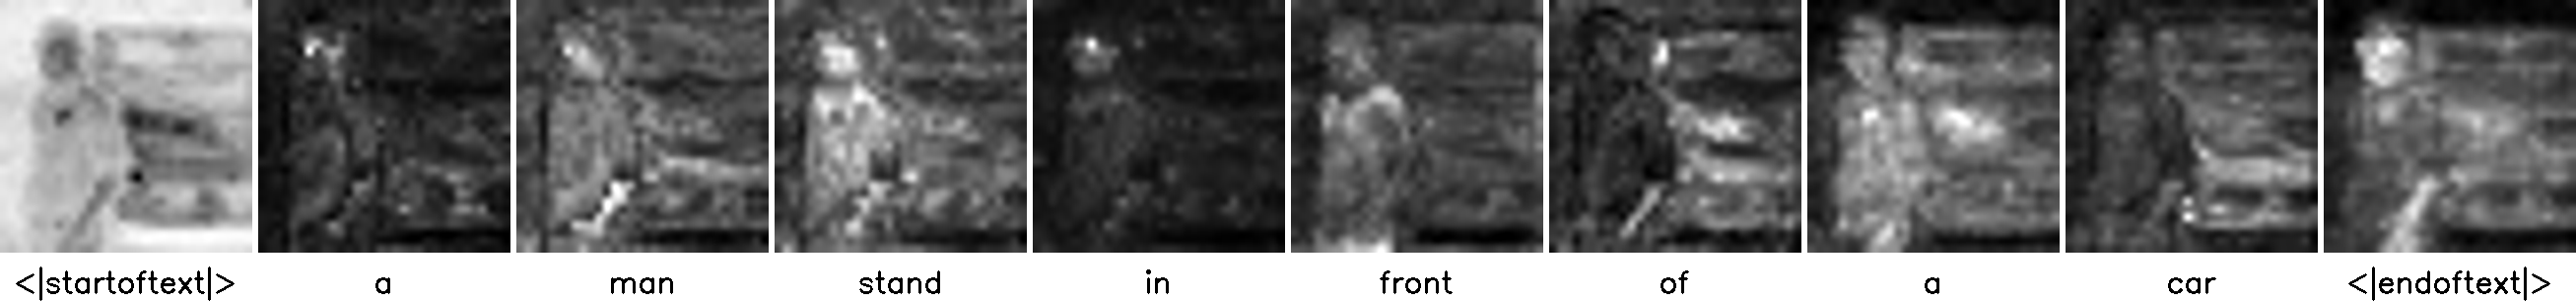

In [6]:
controller = p2p_output[1][3]
tokenizer = pipe.tokenizer
show_cross_attention(attention_store=controller, res=controller.attn_res[0], from_where=["down",'up','mid'],select=0,save_dir='ca-maps')